# Some Examples on Particle Swarm Optimization

### Import packages

In [46]:
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler

### Some interesting loss functions

In [178]:
def scad(b, **kwargs):
    """SCAD loss function.

    Parameters
    ----------
    b : numpy.ndarray
        sets of inputs shape :code:'(n_particles, dimensions)'

    X : numpy.ndarray
        design matrix of inputs shape:code:'(N_obs, dimensions)'

    y : numpy.ndarray
        response vector of inputs shape :code:'(N_obs)'

    lam : float
        penalty parameter lambda.

    a : float
        penalty parameter a.
    
    rho : float
        regularitzation parameter

    Returns
    ----------
    numpy.ndarray
        computed cost of size :code:`(n_particles, )` 
    """
    
    def scad_penalty(beta_hat, lambda_val, a_val):
        """
        Ref
        ----------
        https://andrewcharlesjones.github.io/posts/2020/03/scad/
        """

        is_linear = (np.abs(beta_hat) <= lambda_val)
        is_quadratic = np.logical_and(lambda_val < np.abs(beta_hat), np.abs(beta_hat) <= a_val * lambda_val)
        is_constant = (a_val * lambda_val) < np.abs(beta_hat)
    
        linear_part = lambda_val * np.abs(beta_hat) * is_linear
        quadratic_part = (2 * a_val * lambda_val * np.abs(beta_hat) - beta_hat ** 2 - lambda_val ** 2) / (
                    2 * (a_val - 1)) * is_quadratic
        constant_part = (lambda_val ** 2 * (a_val + 1)) / 2 * is_constant

        return linear_part + quadratic_part + constant_part

    X, y, lam, a, rho = kwargs.values()

    # e is a nxN matrix, n=n_particles and N=n_obs
    e = (y - X.dot(b.T)).T
    penalty = np.zeros(b.shape)

    for i in range(e.shape[0]):
        penalty[i, :] = scad_penalty(b[i, :], lam, a)

    return 0.5 * (1/len(y)) * np.linalg.norm(e, axis=1) ** 2 + rho * penalty.sum(axis=1)

def LASSO(b, **kwargs):
    """LASSO loss
    
    Parameters
    ----------
    b : numpy.ndarray
        sets of inputs shape :code:'(n_particles, dimensions)'
    
    Returns
    ----------
    numpy.ndarray
        computed cost of size :code:'(n_particles, )'
    """
    X, y, lam = kwargs.values()
    
    e = (y - X.dot(b.T)).T
    
    return 0.5 * (1/len(y)) * np.linalg.norm(e, axis=1) ** 2 + lam * np.abs(b).sum(axis=1)


In [230]:
data = pd.read_csv("datasets/waterquality.csv")
scaler = StandardScaler()
data_scale = scaler.fit_transform(data.iloc[:, 1:])
X = data_scale[:, 1:-3]
y = data_scale[:, -2]

In [180]:
print(data.columns[1:-3])

Index(['Depth', 'Chl-a', 'DO', 'Turbity', 'pH', 'TDS', 'T', 'NH4-N', 'NO3-N',
       'TN', 'TP', 'TOC', 'Ca', 'K', 'Mg', 'Na', 'F'],
      dtype='object')


In [398]:
ols = LinearRegression().fit(X, y)
lasso = Lasso(alpha=1).fit(X, y)
ridge = Ridge(alpha=0.5).fit(X, y)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=X.shape[1], options=options)
best_cost, best_pos = optimizer.optimize(scad, iters=100, X=X, y=y.reshape((-1, 1)), lam=1, a=2.5, rho=1)
#best_cost, best_pos = optimizer.optimize(LASSO, iters=100, X=X, y=y.reshape((-1, 1)), lam=1)
print(max(np.abs(best_pos)))

2021-02-27 15:18:00,028 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.523
2021-02-27 15:18:00,344 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.522779015745499, best pos: [-1.04928545e-03 -2.50372402e-03 -1.05912030e-02  2.48587688e-04
 -2.16750334e-03  2.55644343e-03  4.52792646e-04  4.83823686e-03
 -1.27464320e-04 -5.39112970e-04  2.25026114e-05  3.75300817e-03
  1.46339993e-03 -9.86811577e-04 -1.90399264e-03  3.27034902e-04]


0.010591202992604302


In [373]:
ols.coef_.round(2)

array([ 0.04,  0.03, -0.22,  0.05, -0.02,  0.93,  0.31,  0.2 , -0.04,
        0.07, -0.02, -0.08, -0.66, -0.35, -0.36, -0.33])

In [374]:
lasso.coef_.round(2)

array([-0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        0., -0., -0.])

In [375]:
ridge.coef_.round(2)

array([ 0.03,  0.05, -0.22,  0.05, -0.02,  0.84,  0.3 ,  0.19, -0.04,
        0.07, -0.02, -0.07, -0.57, -0.34, -0.32, -0.32])

In [389]:
best_pos.round(2)

array([-0.02, -0.  , -0.  ,  0.04, -0.01,  0.04, -0.01, -0.12,  0.  ,
       -0.04,  0.  ,  0.21, -0.03,  0.  , -0.  ,  0.  ])

In [377]:
m = 100; n=100
xx, yy = np.meshgrid(np.linspace(-2.5,2.5,m), np.linspace(-2.5,2.5,n))
rest = np.repeat(best_pos[2:].reshape((-1, 1)), m*n, 1).T
xxyy = np.array((xx, yy)).reshape(2, -1).T
xxyy_rest = np.hstack([rest, xxyy])
points = np.array(optimizer.pos_history)[-1, :, -2:]

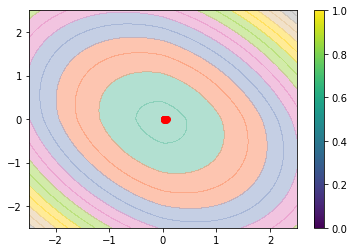

In [388]:
z = scad(xxyy_rest, X=X, y=y.reshape((-1, 1)), lam=1, a=2.5, rho=0.1)
z_ = z.reshape((n, m))
plt.contourf(xx, yy, z_, 15, cmap='Set2',alpha=0.5)
plt.scatter(x=points[:, 0], y=points[:, 1], c="red")
plt.colorbar()
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

Index(['Depth', 'Chl-a', 'DO', 'Turbity', 'pH', 'TDS', 'T', 'NH4-N', 'NO3-N',
       'TN', 'TP', 'TOC', 'Ca', 'K', 'Mg', 'Na', 'F'],
      dtype='object')